In [1]:
import numpy as np

# Scikit Learn does not have its own global random state. It uses the numpy random state instead.
np.random.seed(0)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def train_and_test_classifier(X_train, y_train, X_test, y_test):

    print(f"Shapes before reshaping: ", X_train.shape, X_test.shape)
    X_train = X_train.reshape(len(X_train), -1)
    X_test = X_test.reshape(len(X_test), -1)
    print(f"Shapes after reshaping: ", X_train.shape, X_test.shape)

    y_train[y_train>0] = 1
    y_test[y_test>0] = 1

    # Create a GradientBoostingClassifier object with default hyperparameters
    clf = GradientBoostingClassifier()

    # Train the classifier on the training data
    clf.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = clf.predict(X_test.reshape(len(X_test), -1))
    
    y_true = y_test
    y_true[y_true>0] = 1

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Define the class labels
    class_names = ['Negative', 'Positive']

    # Create a heatmap using Seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Add labels and title
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

    from sklearn.metrics import classification_report

    # Build the classification report
    target_names = ['Negative', 'Positive']
    report = classification_report(y_true, y_pred, target_names=target_names)

    # Print the classification report
    print(report)

In [3]:
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.under_sampling import NeighbourhoodCleaningRule 
# X, y = make_classification(n_classes=2, class_sep=2,
#  weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
#  n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
# print('Original dataset shape {}'.format(Counter(y)))

# ncr = NeighbourhoodCleaningRule()
# X_res, y_res = ncr.fit_resample(X, y)
# print('Resampled dataset shape {}'.format(Counter(y_res)))

In [6]:
import pickle

pipeline_id = "A652_N"
filename = "../data/datasets/" + pipeline_id + ".pickle"
print(f"Loading train/val/test datasets from {filename}.")
file = open(filename, 'rb')
(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(file)
print(f"Shapes of train/val/test data matrices: {X_train.shape}/{X_val.shape}/{X_test.shape}")

Loading train/val/test datasets from ../data/datasets/A652_N.pickle.
Shapes of train/val/test data matrices: (71237, 6, 23)/(20369, 6, 23)/(10219, 6, 23)


# Train a classifier on the original training set

Shapes before reshaping:  (71237, 6, 23) (10219, 6, 23)
Shapes after reshaping:  (71237, 138) (10219, 138)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


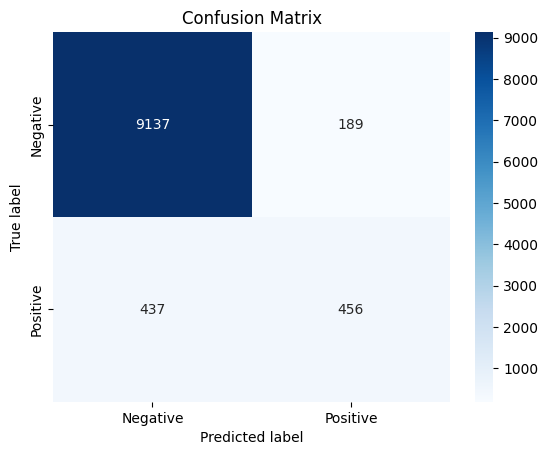

              precision    recall  f1-score   support

    Negative       0.95      0.98      0.97      9326
    Positive       0.71      0.51      0.59       893

    accuracy                           0.94     10219
   macro avg       0.83      0.75      0.78     10219
weighted avg       0.93      0.94      0.93     10219



In [7]:
train_and_test_classifier(X_train, y_train, X_test, y_test)

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np 

def train_pilot_model(X_train, y_train):
    y_eq_zero_idxs = np.where(y_train == 0)[0]
    y_gt_zero_idxs = np.where(y_train > 0)[0]
    print(f"Amounts of neg/pos examples: {len(y_eq_zero_idxs)}/{len(y_gt_zero_idxs)}")

    positive_examples = X_train[y_gt_zero_idxs]
    negative_examples = X_train[y_eq_zero_idxs]

    num_positive_examples = len(positive_examples)
    num_negative_examples = len(negative_examples)
    desired_num_examples = min(num_positive_examples, num_negative_examples)
    print(desired_num_examples)

    positive_indices = np.random.choice(num_positive_examples, size=desired_num_examples, replace=False)
    negative_indices = np.random.choice(num_negative_examples, size=desired_num_examples, replace=False)

    X_balanced = np.concatenate((positive_examples[positive_indices], negative_examples[negative_indices]))
    y_balanced = np.concatenate((np.ones(desired_num_examples), np.zeros(desired_num_examples)))

    assert len(y_balanced) == 2*desired_num_examples

    # Create a GradientBoostingClassifier object with default hyperparameters
    clf = GradientBoostingClassifier()

    # Train the classifier on the training data
    clf.fit(X_balanced, y_balanced)
    
    return clf, X_balanced, y_balanced

def score_negative_examples(clf, X_balanced, y_balanced):
    X_balanced_negative = X_balanced[y_balanced==0]
    y_balanced_negative = y_balanced[y_balanced==0]

    # Get predicted probabilities on the negative samples
    y_proba = clf.predict_proba(X_balanced_negative)

    # The predicted probabilities for the negative class (class 0) are in the first column
    y_proba_negative = y_proba[:, 0]

    # Normalize the probabilities to sum to 1
    y_proba_normalized = y_proba_negative / np.sum(y_proba_negative)

    print(f"Normalized scores for the first 5 negative examples: {y_proba_normalized[:5]}")
    print(f"Correct labels for the first 5 negative examples: {y_balanced_negative[:5]}")
    
    return y_proba_normalized

def sample_from_negative_examples(X_balanced, y_balanced, y_proba_normalized):
    # Create an array of indices corresponding to X_balanced_negative
    X_balanced_negative = X_balanced[y_balanced==0]
    indices = np.arange(len(X_balanced_negative))

    positive_examples = X_balanced[y_balanced==1]
    num_positive_examples = len(positive_examples)

    # Sample the indices using the normalized probabilities
    sampled_indices = np.random.choice(indices, size=num_positive_examples, replace=False, p=y_proba_normalized)

    # Use the sampled indices to get a subset "hard" negative examples
    X_sampled_negative = X_balanced_negative[sampled_indices]

    return X_sampled_negative

In [9]:
def apply_negative_sampling(X_train, y_train):
    original_shape_X_train = X_train.shape
    
    X_train = X_train.reshape(len(X_train), -1)
    y_train[y_train>0] = 1    
    
    ###
    # Now apply the steps of the negative sampling procedure
    ###

    # Step 1: Train "pilot" model
    clf, X_balanced, y_balanced = train_pilot_model(X_train, y_train)

    # Step 2: Score the negative examples with the pilot model
    y_proba_normalized = score_negative_examples(clf, X_balanced, y_balanced)

    # Step 3: Sample the negative examples proportionally to the scores
    X_sampled_negative = sample_from_negative_examples(X_balanced, y_balanced, y_proba_normalized)
    
    positive_examples = X_balanced[y_balanced==1]
    desired_num_examples = len(positive_examples)
    X_train_sampled = np.concatenate((positive_examples, X_sampled_negative))
    y_train_sampled = np.concatenate((np.ones(desired_num_examples), np.zeros(desired_num_examples)))
    X_train_sampled.shape, y_train_sampled.shape
    
    X_train_sampled = X_train_sampled.reshape((len(X_train_sampled), original_shape_X_train[1], original_shape_X_train[2]))
    
    return X_train_sampled, y_train_sampled

In [10]:
X_train_sampled, y_train_sampled = apply_negative_sampling(X_train, y_train)

X_train_sampled.shape, y_train_sampled.shape

Amounts of neg/pos examples: 64270/6967
6967
Normalized scores for the first 5 negative examples: [0.00010424 0.00013193 0.00015948 0.00017103 0.00013947]
Correct labels for the first 5 negative examples: [0. 0. 0. 0. 0.]


((13934, 6, 23), (13934,))

# Train a classifier on the sampled training set

Shapes before reshaping:  (13934, 6, 23) (10219, 6, 23)
Shapes after reshaping:  (13934, 138) (10219, 138)


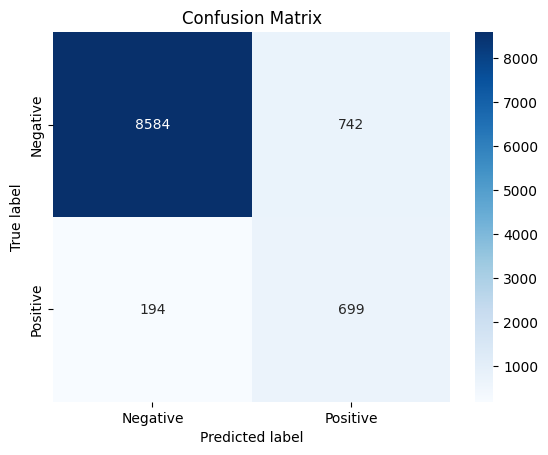

              precision    recall  f1-score   support

    Negative       0.98      0.92      0.95      9326
    Positive       0.49      0.78      0.60       893

    accuracy                           0.91     10219
   macro avg       0.73      0.85      0.77     10219
weighted avg       0.93      0.91      0.92     10219



In [13]:
train_and_test_classifier(X_train_sampled, y_train_sampled, X_test, y_test)

In [18]:
import torch 
def BCELoss_class_weighted(weights):

    def loss(input, target):
        input = torch.clamp(input,min=1e-7,max=1-1e-7)
        bce = - weights[1] * target * torch.log(input) - (1 - target) * weights[0] * torch.log(1 - input)
        return torch.mean(bce)

    return loss

loss = BCELoss_class_weighted
# loss = torch.nn.BCELoss(reduction='none')

weights = torch.rand(10,1)
outputs = torch.rand(10,1)
targets = torch.rand(10,1)

intermediate_losses = loss(outputs, targets)
final_loss = torch.mean(weights*intermediate_losses)

TypeError: BCELoss_class_weighted() takes 1 positional argument but 2 were given